In [5]:
import cv2
import dlib
import numpy as np
import glob
from matplotlib import pyplot as plt
from pylmnn import LargeMarginNearestNeighbor as LMNN
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from Marginal_knn import Marginal_knn
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [57]:
def get_acc(y_pred, y_pred_prob, method):
    lmnn_positive_count = 0
    y_pair_actual = []
    y_pair_pred = []
    counter=0
    for i in range(len(X_test)-1):
        for j in range(i+1,len(X_test)):
            if y_test[i]==y_test[j]:
                y_pair_actual.append(1)
            else:
                y_pair_actual.append(0)
            if method == 'knn':
                if y_pred[i]==y_pred[j]:
                    y_pair_pred.append(max(max(y_pred_prob[i]),max(y_pred_prob[j])))
                else:
                    y_pair_pred.append(0)
                if y_test[i]==y_test[j] and y_pred[i]==y_pred[j]:
                    lmnn_positive_count+=1
                if y_test[i]!=y_test[j] and y_pred[i]!=y_pred[j]:
                    lmnn_positive_count+=1
            if method == 'mknn':
                if y_pred[counter] > 0.5:
                    y_pair_pred.append(1)
                    lmnn_positive_count+=1
                else:
                    y_pair_pred.append(0)
            counter+=1
            
    #print(lmnn_positive_count, ((len(X_test)*(len(X_test)-1))))
    lmnn_acc = lmnn_positive_count*2/((len(X_test)*(len(X_test)-1)))
    return lmnn_acc, y_pair_actual, y_pair_pred
    
def roc_auc_curve(y_pair_actual, y_pair_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_pair_actual, y_pair_pred)  #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_pair_actual, y_pair_pred)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    #print(roc_auc)
    return roc_auc, fpr, tpr

>  Olivetti faces dataset

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces
import warnings
warnings.filterwarnings("ignore")

# Load a data set
bunch = fetch_olivetti_faces(data_home = './data')
#print(type(bunch.data))

pca = PCA(n_components=200)
output_pca = pca.fit_transform(bunch.data)
#print(output_pca.shape)
#print(np.shape(bunch.data))

X_train, X_test, y_train, y_test = train_test_split(output_pca, bunch.target, train_size=0.7, random_state=42)#, stratify=y, random_state=42)

# Set up the hyperparameters
k_neighbors = [3,5,7,10]
n_components, max_iter = output_pca.shape[1], 180

lmnn_acc_knn, roc_knn, fpr_knn, tpr_knn = [],[],[],[] 
lmnn_acc_mknn, roc_mknn, fpr_mknn, tpr_mknn = [],[],[],[]

for k in k_neighbors:
    # Instantiate the metric learner
    lmnn = LMNN(n_neighbors=k, max_iter=max_iter, n_components=n_components)
    
    # Train the metric learner
    lmnn.fit(X_train, y_train)
    lmnn_train_op = lmnn.transform(X_train)
    # Fit the nearest neighbors classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(lmnn_train_op, y_train)
    
    # Compute the k-nearest neighbor test accuracy after applying the learned transformation
    #lmnn_acc = knn.score(lmnn.transform(X_test), y_test)
    lmnn_test_op = lmnn.transform(X_test)
    y_pred_prob = knn.predict_proba(lmnn_test_op)
    y_pred = knn.predict(lmnn_test_op)
    acc, y_pair_actual, y_pair_pred = get_acc(y_pred, y_pred_prob, method='knn')
    #print(y_pair_pred)
    lmnn_acc_knn.append(acc)
    roc_auc1, fpr_, tpr_ = roc_auc_curve(y_pair_actual, y_pair_pred)
    roc_knn.append(roc_auc1)
    fpr_knn.append(fpr_)
    tpr_knn.append(tpr_)
    
    Mknn = Marginal_knn(n_neighbors=k)
    Mknn.fit(lmnn_train_op, y_train)
    y_pred = Mknn.predict(lmnn_test_op)
    acc, y_pair_actual, y_pair_pred = get_acc(y_pred, y_pred_prob, method='mknn')
    lmnn_acc_mknn.append(acc)
    roc_auc2, fpr_, tpr_ = roc_auc_curve(y_pair_actual, y_pred)
    roc_mknn.append(roc_auc2)
    fpr_mknn.append(fpr_)
    tpr_mknn.append(tpr_)
    print("ROC-AUC score with ",str(k)," neighbors")
    print("K-NN:", roc_auc1['micro'], "\tM-KNN:", roc_auc2['micro'])

ROC-AUC score with  3  neighbors
K-NN: 0.852800192996196 	M-KNN: 0.8638126888006264
ROC-AUC score with  5  neighbors
K-NN: 0.814525236350414 	M-KNN: 0.9247861133642873
ROC-AUC score with  7  neighbors
K-NN: 0.8147817779424927 	M-KNN: 0.9369169906578653
ROC-AUC score with  10  neighbors
K-NN: 0.7414454086484673 	M-KNN: 0.9294838400648915


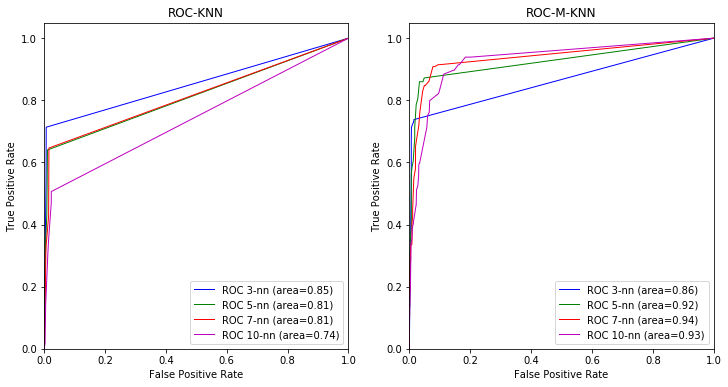

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-KNN')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC-M-KNN')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
lw = 1
x = 0
color = ['b', 'g', 'r', 'm']
for i in range(len(k_neighbors)):
    ax1.plot(fpr_knn[i][x], tpr_knn[i][x], color=color[i],
             lw=lw, label='ROC '+str(k_neighbors[i])+'-nn (area=%0.2f)' % roc_knn[i][x])
    ax2.plot(fpr_mknn[i][x], tpr_mknn[i][x], color=color[i],
             lw=lw, label='ROC '+str(k_neighbors[i])+'-nn (area=%0.2f)' % roc_mknn[i][x])
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    ax1.legend(loc="lower right")
    ax2.legend(loc="lower right")
plt.show()

>  Labelled Faces in Wild dataset

In [228]:
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
def get_face(files):
    faces = []
    for file in files:
        image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        if len(image.shape) > 2:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
        face = face_cascade.detectMultiScale(gray, 1.3, 5)
        if len(face) == 0:
            return faces, False
        face = gray[face[0][0]:face[0][0]+face[0][2], face[0][1]:face[0][1]+face[0][3]]
        face = cv2.resize(face, (47,62)) #(47,62) #(125,125), (94,125)
        #cv2.imshow('face',face)
        #cv2.waitKey(10)
        ace = face.astype('float32')
        face = cv2.normalize(face,0,255,cv2.NORM_MINMAX)
        face = face.flatten()
        #face = face.astype('float32')
        #face /= 255.0
        faces.append(face)
        '''
        img = image.copy()
        for (x,y,w,h) in faces:
            img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),5)
        
        plt.figure(figsize=(10,10))
        plt.axis("off")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
        '''
    return faces, True

In [170]:
#-- Read file conatining image paths ---#
files = glob.glob('./extract/*')
#name_file = open('./all_images.txt', 'r')
#lines = name_file.readlines()

In [229]:
#--- Read images, prepare training and testing dataset ---#
images = []
labels = []
label_count = 0
#face_train, face_test, y_train, y_test = [], [], [], []
for file in files:
    #print(line)
    img_files = glob.glob(file+'/*')
    name, count = img_files[0].split('/')[-2].split('.')[0], len(img_files)
    if int(count)>11 :
        #files = glob.glob('./lfw-deepfunneled/'+name+'/*')
        #print(line)
        faces, flag = get_face(img_files)
        if flag:
            tmp = 0
            for i in range(10): #for face in faces: 
                #if tmp!=2 and tmp != 3 and tmp!=6 and tmp!=9 and tmp !=11 and tmp!=13:
                '''
                if tmp != 3 and tmp!=5 and tmp!=6: #and tmp!=9 and tmp!=11:
                    face_train.append(faces[i])
                    y_train.append(label_count)
                else:
                    face_test.append(faces[i])
                    y_test.append(label_count)
                tmp+=1
                '''
                images.append(faces[i])
                labels.append(label_count)
            label_count+=1
        else:
            pass
            #print("Notfound")

n_classes = label_count
print("Number of classes:",n_classes)
#print("Training data shape:",np.shape(face_train)," Testing data shape:", np.shape(face_test))

Number of classes: 54


In [230]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, random_state=420)#, stratify=y, random_state=42)
#images = face_train
#print(np.shape(X_train))
pca = PCA(n_components=0.99)
X_train = pca.fit_transform(X_train)
print(np.shape(X_train))
X_test = pca.transform(X_test)

(432, 326)


In [236]:
k_neighbors = [3,5,7,10]
n_components, max_iter = X_train.shape[1], 200

lmnn_acc_knn, roc_knn, fpr_knn, tpr_knn = [],[],[],[] 
lmnn_acc_mknn, roc_mknn, fpr_mknn, tpr_mknn = [],[],[],[]

for k in k_neighbors:
    # Instantiate the metric learner
    lmnn = LMNN(n_neighbors=k, max_iter=max_iter, n_components=n_components)
    
    # Train the metric learner
    lmnn.fit(X_train, y_train)
    lmnn_train_op = lmnn.transform(X_train)
    # Fit the nearest neighbors classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(lmnn_train_op, y_train)
    
    # Compute the k-nearest neighbor test accuracy after applying the learned transformation
    #lmnn_acc = knn.score(lmnn.transform(X_test), y_test)
    lmnn_test_op = lmnn.transform(X_test)
    y_pred_prob = knn.predict_proba(lmnn_test_op)
    y_pred = knn.predict(lmnn_test_op)
    acc, y_pair_actual, y_pair_pred = get_acc(y_pred, y_pred_prob, method='knn')
    #print(y_pair_pred)
    lmnn_acc_knn.append(acc)
    roc_auc1, fpr_, tpr_ = roc_auc_curve(y_pair_actual, y_pair_pred)
    roc_knn.append(roc_auc1)
    fpr_knn.append(fpr_)
    tpr_knn.append(tpr_)
    
    Mknn = Marginal_knn(n_neighbors=k)
    Mknn.fit(lmnn_train_op, y_train)
    y_pred = Mknn.predict(lmnn_test_op)
    acc, y_pair_actual, y_pair_pred = get_acc(y_pred, y_pred_prob, method='mknn')
    lmnn_acc_mknn.append(acc)
    roc_auc2, fpr_, tpr_ = roc_auc_curve(y_pair_actual, y_pred)
    roc_mknn.append(roc_auc2)
    fpr_mknn.append(fpr_)
    tpr_mknn.append(tpr_)
    print("ROC-AUC score with ",str(k)," neighbors")
    print("K-NN:", roc_auc1['micro'], "\tM-KNN:", roc_auc2['micro'])

ROC-AUC score with  3  neighbors
K-NN: 0.5907388164846777 	M-KNN: 0.6663587530820712
ROC-AUC score with  5  neighbors
K-NN: 0.5923230010567101 	M-KNN: 0.700730010567101
ROC-AUC score with  7  neighbors
K-NN: 0.572367030644593 	M-KNN: 0.7116370200774921
ROC-AUC score with  10  neighbors
K-NN: 0.577052659387108 	M-KNN: 0.6955653399084184


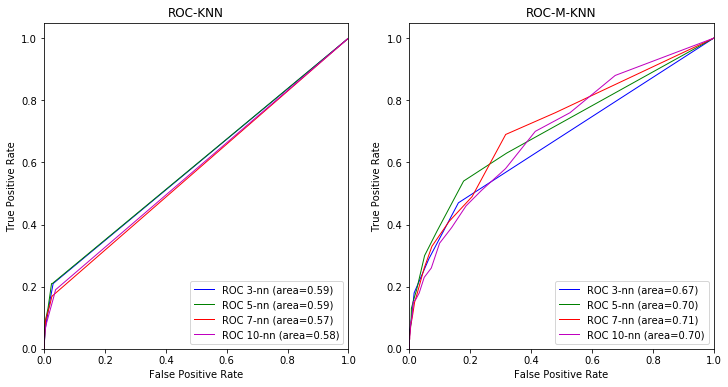

In [237]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-KNN')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC-M-KNN')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
lw = 1
x = 0
color = ['b', 'g', 'r', 'm']
for i in range(len(k_neighbors)):
    ax1.plot(fpr_knn[i][x], tpr_knn[i][x], color=color[i],
             lw=lw, label='ROC '+str(k_neighbors[i])+'-nn (area=%0.2f)' % roc_knn[i][x])
    ax2.plot(fpr_mknn[i][x], tpr_mknn[i][x], color=color[i],
             lw=lw, label='ROC '+str(k_neighbors[i])+'-nn (area=%0.2f)' % roc_mknn[i][x])
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    ax1.legend(loc="lower right")
    ax2.legend(loc="lower right")
plt.show()